* Virtual Idol과 Real Idol 분석 - NLP 파트
* 워드클라우드, TF-IDF 코사인 유사도, unigram / n-gram 네트워크, CONCOR 분석

In [ ]:
import pandas as pd
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import ast
from itertools import chain

from konlpy.tag import Okt
from kiwipiepy import Kiwi

from collections import Counter
from wordcloud import WordCloud
import networkx as nx
from PIL import Image
import plotly.graph_objects as go
import community as community_louvain


# uv add python-louvain
#import community as community_louvain

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity


# 0. 함수정의

In [2]:
def parse_list_str(x):
    # NaN/None 방어
    if x is None:
        return []
    # 이미 list면 그대로
    if isinstance(x, list):
        return x
    # 문자열이면 리스트로 파싱 시도
    if isinstance(x, str):
        x = x.strip()
        if x == "" or x == "[]":
            return []
        try:
            v = ast.literal_eval(x)   # "['안녕']" -> ['안녕']
            return v if isinstance(v, list) else []
        except (ValueError, SyntaxError):
            return []  # 파싱 실패하면 빈 리스트로
    return []

In [3]:
def keep_topk_per_row(M, k, symmetric="max"):
    """
    M: (n,n) similarity matrix (numpy array)
    k: keep top-k neighbors per node (per row), excluding diagonal
    symmetric:
      - "max": keep edge if either direction keeps it (union)  ✅ 추천
      - "min": keep edge only if both directions keep it (mutual top-k, intersection)
    """
    M = M.copy()
    np.fill_diagonal(M, 0.0)

    n = M.shape[0]
    out = np.zeros_like(M)

    for i in range(n):
        row = M[i]
        # k가 n-1보다 크면 전부 유지
        kk = min(k, n - 1)
        if kk <= 0:
            continue

        # 상위 kk 인덱스 (정렬 전체 하지 않고 빠르게)
        idx = np.argpartition(row, -kk)[-kk:]
        out[i, idx] = row[idx]

    if symmetric == "max":
        out = np.maximum(out, out.T)
    elif symmetric == "min":
        out = np.minimum(out, out.T)
    else:
        raise ValueError("symmetric must be 'max' or 'min'")

    return out

In [4]:
# 3) UCINET DL(fullmatrix)로 저장
def save_ucinet_dl_fullmatrix(df, path):
    labels = ", ".join(df.index.tolist())
    n = df.shape[0]
    with open(path, "w", encoding="CP949") as f:
        f.write(f"DL n={n}\n")
        f.write("format=fullmatrix\n")
        f.write("labels:\n")
        f.write(labels + "\n")
        f.write("data:\n")
        for row in df.values:
            f.write(" ".join(f"{v:.6f}" for v in row) + "\n")

In [ ]:
def plotly_network_ppt(G, title="N-gram Network", label_top=30, out_png=None, out_svg=None):
    # 1) Layout: spring_layout은 seed 고정 + iterations 늘리면 안정적
    pos = nx.spring_layout(G, seed=42, k=0.18, iterations=300)

    # 2) Community detection (색상용)
    # (가중치 쓰려면 weight='weight')
    part = community_louvain.best_partition(G, weight="weight")
    communities = np.array([part[n] for n in G.nodes()])
    n_comms = len(set(communities))

    # 3) Node size: weighted degree(=strength)
    strength = dict(G.degree(weight="weight"))
    svals = np.array([strength[n] for n in G.nodes()])
    # 보기 좋게 스케일: sqrt + min/max
    node_size = 10 + 35 * (np.sqrt(svals) - np.sqrt(svals).min()) / (np.sqrt(svals).ptp() + 1e-9)

    # 4) Label: 상위 label_top개만 텍스트 표시
    top_nodes = set([n for n, _ in sorted(strength.items(), key=lambda x: x[1], reverse=True)[:label_top]])
    node_text = [n if n in top_nodes else "" for n in G.nodes()]

    # 5) Edge traces (Plotly는 edge를 한 trace로 이어 그리면 빠르고 예쁨)
    edge_x, edge_y = [], []
    edge_w = []
    for u, v, d in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_w.append(d.get("weight", 1.0))

    edge_w = np.array(edge_w) if len(edge_w) else np.array([1.0])
    # 두께 스케일 (PPT용 과하지 않게)
    w_scaled = 0.5 + 3.0 * (edge_w - edge_w.min()) / (edge_w.ptp() + 1e-9)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        mode="lines",
        line=dict(width=1.0, color="rgba(120,120,120,0.25)"),
        hoverinfo="none"
    )

    # 6) Node trace
    node_x = [pos[n][0] for n in G.nodes()]
    node_y = [pos[n][1] for n in G.nodes()]

    hover = []
    for n in G.nodes():
        hover.append(f"{n}<br>strength: {strength[n]:.3f}<br>community: {part[n]}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        text=node_text,
        textposition="top center",
        hovertext=hover,
        hoverinfo="text",
        marker=dict(
            size=node_size,
            color=communities,
            colorscale="Turbo",
            showscale=True,
            colorbar=dict(title="Community"),
            line=dict(width=1, color="rgba(30,30,30,0.4)")
        )
    )

    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title=title,
        template="plotly_white",
        width=1200, height=800,
        margin=dict(l=20, r=20, t=60, b=20),
        xaxis=dict(showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False),
    )

    # 7) Export (PPT용)
    # pip install -U kaleido
    if out_png:
        fig.write_image(out_png, scale=3)  # 고해상도
    if out_svg:
        fig.write_image(out_svg)

    return fig

# 사용 예:
# fig = plotly_network_ppt(G, title=f"{grp_name} 아이돌 N-gram 네트워크", label_top=35,
#                          out_png=f"{grp_name}_ngram_network.png",
#                          out_svg=f"{grp_name}_ngram_network.svg")
# fig.show()


# 1. 데이터 불러오기

In [6]:
df = pd.read_csv(
    "../cocacoca0810/data/01_raw/youtube_comments_origin.csv",
)

df.head()

,video_id,comment_id,comment_text,like_count,published_at
0,k5O1F_IS0mU,Ugykjh0_hVuTgqN8doR4AaABAg,그냥 얘들아 내가 진짜 ㅠ 애정한다 ㅠ 나 이렇게 애정해본 아이돌이 너네가 처음이고...,0,2026-01-31T15:59:29Z
1,k5O1F_IS0mU,Ugx1c4OKEnkVwGWBlFB4AaABAg,눈물이 난다,2,2026-01-23T04:29:25Z
2,k5O1F_IS0mU,UgwaAbmKOm2vwOgFEFp4AaABAg,이 노래도 겁나 좋네,2,2026-01-20T01:52:56Z
3,k5O1F_IS0mU,UgzquReVBuSocVLtI7t4AaABAg,"패러블, 이제 뉴세돌로 리와인드 다시 찍어 올려라!!! 이세돌 더 이쁜 버전으로 보...",3,2026-01-19T11:10:22Z
4,k5O1F_IS0mU,UgwM02x2Puib48rQTuF4AaABAg,언제 들어도 행복하고 좋은 노래..,2,2026-01-16T02:53:32Z


In [7]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 254637 entries, 0 to 254636
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   video_id      254637 non-null  str  
 1   comment_id    254637 non-null  str  
 2   comment_text  254516 non-null  str  
 3   like_count    254637 non-null  int64
 4   published_at  254637 non-null  str  
dtypes: int64(1), str(4)
memory usage: 9.7 MB


# 2. Word Cloud

In [249]:
## tokenized data

df = pd.read_csv(
    "../cocacoca0810/data/01_raw/subsets/Full_youtube_comments_N_A.csv",
)

df.columns.values[0] = 'video_id'

df.head()

,video_id,keywords
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ..."
1,k5O1F_IS0mU,['눈물']
2,k5O1F_IS0mU,"['노래', '좋다']"
3,k5O1F_IS0mU,"['패러블', '다시', '이쁘다', '버전']"
4,k5O1F_IS0mU,"['언제', '행복하다', '좋다', '노래']"


In [250]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 218104 entries, 0 to 218103
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   video_id  218104 non-null  str  
 1   keywords  67496 non-null   str  
dtypes: str(2)
memory usage: 3.3 MB


In [251]:
df = df.dropna()
df.info()

<class 'pandas.DataFrame'>
Index: 67496 entries, 0 to 218100
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   video_id  67496 non-null  str  
 1   keywords  67496 non-null  str  
dtypes: str(2)
memory usage: 1.5 MB


In [252]:
df['video_id'].value_counts()

# 라이즈 영상에 단어 리스트가 133 밖에 없는걸 확인할 수 있다.

video_id
6ZUIwj3FgUY    19903
rDFUl2mHIW4    15665
EYG4ROejmyI    10358
B1ShLiq3EVc     4784
8L001YT4k6k     4199
T_gJpnjJsnk     3472
fff8P0kYexQ     2949
TVqEwvbZP30     2496
iUw3LPM7OBU     2072
k5O1F_IS0mU     1019
bltjk6NfDQM      438
3_b5oKGndn0      141
Name: count, dtype: int64

In [253]:
video_to_group = {
    "8L001YT4k6k": "PLAVE",
    "EYG4ROejmyI": "PLAVE",
    "T_gJpnjJsnk": "PLAVE",

    "bltjk6NfDQM": "IVE",
    "B1ShLiq3EVc": "IVE",
    "6ZUIwj3FgUY": "IVE",
    
    "iUw3LPM7OBU": "RIIZE",
    "3_b5oKGndn0": "RIIZE",
    "TVqEwvbZP30": "RIIZE",
    
    "k5O1F_IS0mU": "ISEGYE IDOL",
    "rDFUl2mHIW4": "ISEGYE IDOL",
    "fff8P0kYexQ": "ISEGYE IDOL"
}

In [254]:
df["group"] = df["video_id"].map(video_to_group)

In [255]:
df.head()

,video_id,keywords,group
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ...",ISEGYE IDOL
1,k5O1F_IS0mU,['눈물'],ISEGYE IDOL
2,k5O1F_IS0mU,"['노래', '좋다']",ISEGYE IDOL
3,k5O1F_IS0mU,"['패러블', '다시', '이쁘다', '버전']",ISEGYE IDOL
4,k5O1F_IS0mU,"['언제', '행복하다', '좋다', '노래']",ISEGYE IDOL


In [256]:
df.info()

<class 'pandas.DataFrame'>
Index: 67496 entries, 0 to 218100
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   video_id  67496 non-null  str  
 1   keywords  67496 non-null  str  
 2   group     67496 non-null  str  
dtypes: str(3)
memory usage: 2.1 MB


In [257]:
# 각 그룹별 단어 리스트 개수
df['group'].value_counts()

group
IVE            25125
ISEGYE IDOL    19633
PLAVE          18029
RIIZE           4709
Name: count, dtype: int64

In [258]:
# V와 R 나누기 위한 컬럼 추가
df['is_real'] = df['group'].str.contains(r'RIIZE|IVE', case=False)
df.head()

,video_id,keywords,group,is_real
0,k5O1F_IS0mU,"['진짜', '애정', '애정', '아이돌', '처음', '콘서트', '아이돌', ...",ISEGYE IDOL,False
1,k5O1F_IS0mU,['눈물'],ISEGYE IDOL,False
2,k5O1F_IS0mU,"['노래', '좋다']",ISEGYE IDOL,False
3,k5O1F_IS0mU,"['패러블', '다시', '이쁘다', '버전']",ISEGYE IDOL,False
4,k5O1F_IS0mU,"['언제', '행복하다', '좋다', '노래']",ISEGYE IDOL,False


In [259]:
# group별로 1000 개씩 랜덤 샘플링하기.

col = "group"
n_per_group = 4000
seed = 42

sampled_df = (
    df.groupby(col, group_keys=False)
      .apply(lambda g: g.assign(group=g.name)
             .sample(n=min(n_per_group, len(g)), random_state=seed))
      .reset_index(drop=True)
)

sampled_df.head()

,video_id,keywords,is_real,group
0,rDFUl2mHIW4,"['진짜', '좋다', '수고']",False,ISEGYE IDOL
1,rDFUl2mHIW4,"['세구', '사랑']",False,ISEGYE IDOL
2,rDFUl2mHIW4,"['우리', '따갑다']",False,ISEGYE IDOL
3,fff8P0kYexQ,"['비챤', '섹시']",False,ISEGYE IDOL
4,rDFUl2mHIW4,"['키딩키딩', '아예', '아예']",False,ISEGYE IDOL


In [260]:
sampled_df.shape

(16000, 4)

In [261]:
sampled_df['group'].value_counts()

group
ISEGYE IDOL    4000
IVE            4000
PLAVE          4000
RIIZE          4000
Name: count, dtype: int64

In [262]:
sampled_real_df = sampled_df[sampled_df['is_real']]

In [263]:
# 개수 확인
sampled_real_df['is_real'].value_counts()

is_real
True    8000
Name: count, dtype: int64

In [264]:
## 불용어

stopwords = ['아이브', '라이즈', '이세돌', '플레이브', '진짜', '지금', '너무',
    '같은', '다시', '그냥', '제일', '얼마나', '잠깐', '같은데', '많은', '항상', '자꾸',
    '역시', '있는', '우리', '오늘', '완전', '미친', '미쳤다', '대박', '계속',
    '어제', '내일', '이번', '다음', '언제', '자주', '가끔', '처음', '마지막', '요즘',
    '입니다', '화이팅', '진심', '너희', '아니', '아예', '없는',
    '위해', '아이돌', '레이브', '있다'
]

filler_stopwords = [
    "그냥", "약간", "좀", "뭔가", "이런", "저런",
    "같은", "같다", "같아요",
    "이렇게", "저렇게", "어떻게",
]

context_stopwords = [
    "여러분", "여기", "저기",
    "영상", "방송", "무대",
    "노래", "음악",
    "사람", "생각", "느낌",
]

stopwords = set(
    stopwords
    + filler_stopwords
    + context_stopwords
)


In [265]:
col = "keywords"
word_list = []

sampled_real_df[col] = sampled_real_df[col].map(parse_list_str)

sampled_real_df[col].head()

4000                               [제일, 좋다]
4001                           [이서, 언니, 예뽀]
4002                                   [르망]
4003    [진짜, 이쁘다, 트와이스, 관심, 없다, 처음, 관심, 가지]
4004                                 [심심하다]
Name: keywords, dtype: object

In [235]:
stop_set = set(stopwords)

word_list = [w for w in chain.from_iterable(sampled_real_df[col]) if w not in stop_set]

In [236]:
len(word_list)

28444

<>:3: DeprecationWarning: invalid escape sequence '\p'
<>:3: DeprecationWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_3444\3242140999.py:3: DeprecationWarning: invalid escape sequence '\p'
  image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")


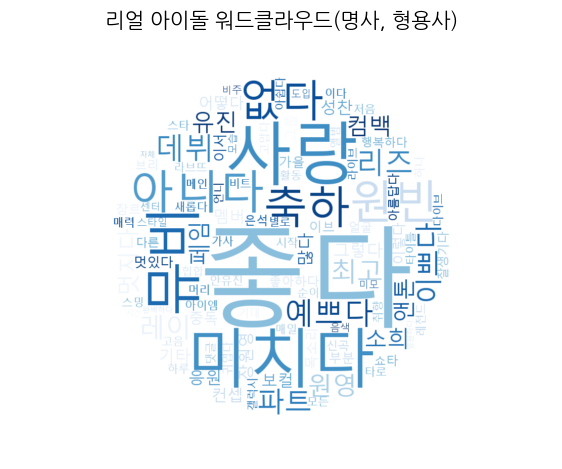

In [237]:
counter = Counter(word_list)

image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")
mask_img = np.array(image)

wc = WordCloud(
    font_path = "C:/Windows/Fonts/malgun.ttf",      # 중요!
    background_color="white",
    mask=mask_img,
    width=800,
    height=400,
    colormap="Blues"
)

wc.generate_from_frequencies(dict(counter.most_common(100)))

plt.figure(figsize=(7,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('리얼 아이돌 워드클라우드(명사, 형용사)', fontsize=15)
plt.show()

In [245]:
sampled_virtual_df = sampled_df[~sampled_df['is_real']]

In [246]:
col = "keywords"
word_list = []

sampled_virtual_df[col] = sampled_virtual_df[col].map(parse_list_str)

sampled_virtual_df[col].head()

0      [진짜, 좋다, 수고]
1          [세구, 사랑]
2         [우리, 따갑다]
3          [비챤, 섹시]
4    [키딩키딩, 아예, 아예]
Name: keywords, dtype: object

In [240]:
stop_set = set(stopwords)

word_list = [w for w in chain.from_iterable(sampled_virtual_df[col]) if w not in stop_set]

In [241]:
len(word_list)

32596

<>:3: DeprecationWarning: invalid escape sequence '\p'
<>:3: DeprecationWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_3444\4252196323.py:3: DeprecationWarning: invalid escape sequence '\p'
  image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")


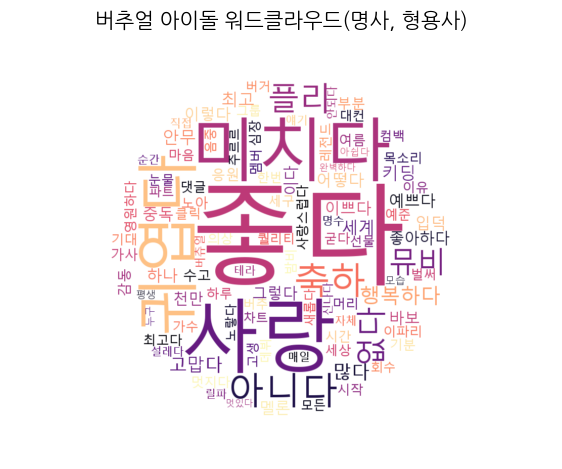

In [242]:
counter = Counter(word_list)

image = Image.open("C:\potenup3\pj01-data-analysis\images\circle.png")
mask_img = np.array(image)

wc = WordCloud(
    font_path = "C:/Windows/Fonts/malgun.ttf",      # 중요!
    background_color="white",
    mask=mask_img,
    width=800,
    height=400,
    colormap="magma"
)

wc.generate_from_frequencies(dict(counter.most_common(100)))

plt.figure(figsize=(7,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('버추얼 아이돌 워드클라우드(명사, 형용사)', fontsize=15)
plt.show()

# 3. TF-IDF 벡터라이져

## 1) 리얼 TF-IDF

In [375]:
# 리스트를 공백을 기준으로한 문서들로 나눈 문자열로 하나의 리스트 만들기.
col = 'keywords'
sampled_real_df["tf-idf_text"] = sampled_real_df[col].apply(
    lambda xs: " ".join(
        w for w in xs
        if isinstance(w, str) and w not in stopwords
    )
)

sampled_real_df["tf-idf_text"].head()

4000                      좋다
4001                이서 언니 예뽀
4002                      르망
4003    이쁘다 트와이스 관심 없다 관심 가지
4004                    심심하다
Name: tf-idf_text, dtype: str

In [376]:
doc_list = []

for doc in sampled_real_df["tf-idf_text"]:
    doc_list.append(doc)

doc_list[:5]

['좋다', '이서 언니 예뽀', '르망', '이쁘다 트와이스 관심 없다 관심 가지', '심심하다']

In [377]:
len(doc_list)

8000

In [369]:
# 1) TF-IDF (docs x terms)
vec = TfidfVectorizer()  # 한국어면 tokenizer를 형태소로 바꾸는 게 보통 더 좋음
X = vec.fit_transform(doc_list)
terms = vec.get_feature_names_out()


In [370]:
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
mean_tfidf

array([7.39605527e-05, 1.37476524e-04, 1.20077664e-04, ...,
       1.32428999e-04, 4.73426028e-03, 9.90535628e-05], shape=(4988,))

In [371]:
tfidf_rank = sorted(
    zip(terms, mean_tfidf),
    key=lambda x: x[1],
    reverse=True
)

tfidf_rank[:50]

[('좋다', np.float64(0.08907344984841076)),
 ('사랑', np.float64(0.03358984350733303)),
 ('미치다', np.float64(0.025793965462635425)),
 ('예쁘다', np.float64(0.017421046470434142)),
 ('축하', np.float64(0.01716466124824187)),
 ('뮤비', np.float64(0.015431325448645788)),
 ('이쁘다', np.float64(0.015096900977719934)),
 ('원빈', np.float64(0.015063775556623178)),
 ('데뷔', np.float64(0.014730114815393821)),
 ('최고', np.float64(0.013937287534590854)),
 ('리즈', np.float64(0.012148560075698549)),
 ('레이', np.float64(0.010456124784689566)),
 ('아니다', np.float64(0.010286446537979773)),
 ('없다', np.float64(0.009370129728817816)),
 ('파트', np.float64(0.008836503891817614)),
 ('원영', np.float64(0.008677830044577447)),
 ('멋지다', np.float64(0.008556550872121404)),
 ('유진', np.float64(0.007891351385603141)),
 ('페임', np.float64(0.007891164963548964)),
 ('소희', np.float64(0.007703024972883488)),
 ('앤톤', np.float64(0.007666402072258526)),
 ('컴백', np.float64(0.007585140198348293)),
 ('중독', np.float64(0.007540683283253185)),
 ('이브', n

In [372]:
X.toarray().shape[1]

4988

## 2) 버추얼 TF-IDF

In [383]:
# 리스트를 공백을 기준으로한 문서들로 나눈 문자열로 하나의 리스트 만들기.
col = 'keywords'
sampled_virtual_df["tf-idf_text"] = sampled_virtual_df[col].apply(
    lambda xs: " ".join(
        w for w in xs
        if isinstance(w, str) and w not in stopwords
    )
)

sampled_virtual_df["tf-idf_text"].head()

0    좋다 수고
1    세구 사랑
2      따갑다
3    비챤 섹시
4     키딩키딩
Name: tf-idf_text, dtype: str

In [384]:
doc_list = []

for doc in sampled_virtual_df["tf-idf_text"]:
    doc_list.append(doc)

print(len(doc_list))
doc_list[:5]

8000


['좋다 수고', '세구 사랑', '따갑다', '비챤 섹시', '키딩키딩']

In [328]:
vec = TfidfVectorizer()
X = vec.fit_transform(doc_list)
terms = vec.get_feature_names_out()

In [329]:
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()

tfidf_rank = sorted(
    zip(terms, mean_tfidf),
    key=lambda x: x[1],
    reverse=True
)

tfidf_rank[:50]

[('좋다', np.float64(0.08274624738087631)),
 ('사랑', np.float64(0.037373456583935864)),
 ('미치다', np.float64(0.03211007589965188)),
 ('축하', np.float64(0.02864880928861802)),
 ('귀엽다', np.float64(0.026070453490757775)),
 ('아니다', np.float64(0.016152881301925485)),
 ('행복하다', np.float64(0.013125914464919375)),
 ('플리', np.float64(0.011861926397237814)),
 ('뮤비', np.float64(0.010821600500014395)),
 ('천만', np.float64(0.010722288733144873)),
 ('최고', np.float64(0.010128315220689046)),
 ('키딩', np.float64(0.00992560481020361)),
 ('없다', np.float64(0.0090881370232203)),
 ('고맙다', np.float64(0.008067878469520924)),
 ('이쁘다', np.float64(0.007960590302469968)),
 ('중독', np.float64(0.007958484642980082)),
 ('예쁘다', np.float64(0.007795418781791621)),
 ('많다', np.float64(0.007758491637773385)),
 ('세계', np.float64(0.007440284868911852)),
 ('멜론', np.float64(0.007084875510239801)),
 ('바보', np.float64(0.007073908407783374)),
 ('최고다', np.float64(0.0067327602143718275)),
 ('입덕', np.float64(0.006683802132732514)),
 ('수고',

In [330]:
X.toarray().shape[1]

5375

### TF-IDF 랭킹 엑셀 만들기

In [304]:
## TF-IDF 랭킹 엑셀 만들기
normalized_score = mean_tfidf / mean_tfidf.max()

# dataframe
df_tfidf = pd.DataFrame({
    "keyword": terms,
    "mean_tfidf": mean_tfidf,
    "normalized_score": normalized_score
})

# 정렬 + rank
df_tfidf = (
    df_tfidf
    .sort_values("normalized_score", ascending=False)
    .reset_index(drop=True)
)

df_tfidf["rank"] = df_tfidf.index + 1

df_tfidf = df_tfidf[["rank", "keyword", "mean_tfidf", "normalized_score"]]

df_tfidf.head(30).to_excel(
    "tfidf_keyword_ranking_top20.xlsx",
    index=False
)

# 4. CONCOR 분석 시각화 파일 만들기

## 1) .dl 파일 만들기 - 노드 개수 줄이기

In [352]:
grp_name = 'Real'

# n개의 단어만 시각화 하기
n = 80
k = 5
t = 0.25
symmetric_mode = "min"

vec = TfidfVectorizer(
    max_features=n,
    min_df=5,            # 너무 희귀한 단어 제거
    max_df=0.8           # 너무 흔한 단어 제거
)
X = vec.fit_transform(doc_list)
terms = vec.get_feature_names_out()


mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
top_idx = np.argsort(mean_tfidf)[::-1][:n]   # 예: 상위 n개 단어만

X_top = X[:, top_idx]
terms_top = terms[top_idx]

M_cos = cosine_similarity(X_top.T)  # (3000 x 3000)면 manageable
np.fill_diagonal(M_cos, 0.0)

M_topk = keep_topk_per_row(M_cos, k=k, symmetric=symmetric_mode)
M_topk[M_topk < t] = 0.0

dfM = pd.DataFrame(M_cos, index=terms_top, columns=terms_top)

save_ucinet_dl_fullmatrix(dfM, f"word_similarity_{grp_name}.dl")
print(f"Saved: word_similarity_{grp_name}.dl")

Saved: word_similarity_Real.dl


In [353]:
## 단어 빈도수로 노드 크기 바꾸는 UCINET6 .att 파일 생성
# 1) CountVectorizer로 단어 빈도
cv = CountVectorizer(vocabulary=terms_top)
C = cv.fit_transform(doc_list)

term_freq = np.asarray(C.sum(axis=0)).ravel()

# 2) UCINET용 DataFrame (ID 필수)
df_att = pd.DataFrame({
    "ID": terms_top,        # 네트워크 노드 라벨과 반드시 동일
    "freq": term_freq
})

# 3) 탭 구분 + CP949 인코딩으로 저장
df_att.to_csv(
    f"word_freq_{grp_name}.att",
    sep="\t",               # 🔥 중요
    index=False,
    encoding="CP949"
)


# 5. N-gram 분석

## 1) Unigram

nodes: 80 edges: 53


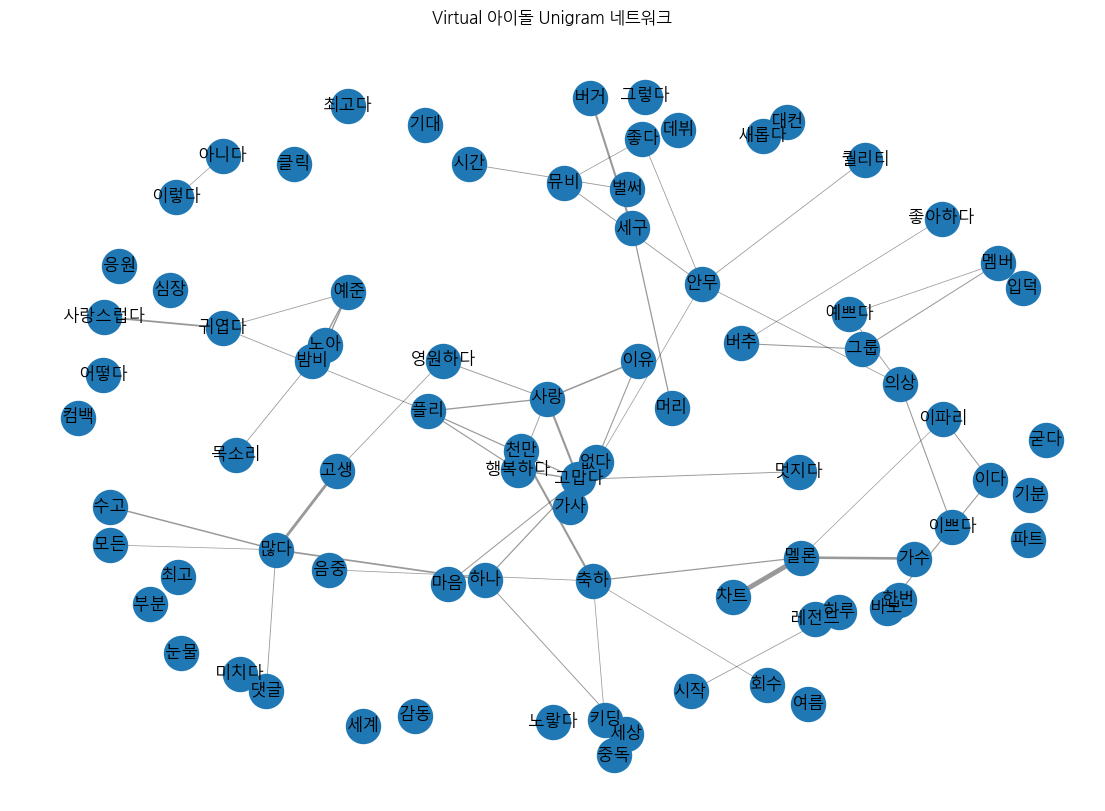

In [314]:
k = 10
symmetric_mode = "min"

M_plot = keep_topk_per_row(M_cos, k=k, symmetric=symmetric_mode)

vals = M_plot[M_plot > 0]
t = np.percentile(vals, 80)   # 상위 30%만 유지
M_plot[M_plot < t] = 0.0

G = nx.Graph()
G.add_nodes_from(terms_top)

# (i<j) 상삼각만 돌면서 엣지 추가
n = len(terms_top)
for i in range(n):
    for j in range(i+1, n):
        w = float(M_plot[i, j])
        if w > 0:
            G.add_edge(terms_top[i], terms_top[j], weight=w)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

pos = nx.spring_layout(G, seed=42, k=0.2)  # k는 퍼짐 정도 (작으면 더 뭉침)

# 엣지 두께를 weight로
weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
widths = 0.5 + 3.0 * (weights - weights.min()) / (np.ptp(weights) + 1e-9)

plt.figure(figsize=(14, 10))
plt.title(f"{grp_name} 아이돌 Unigram 네트워크")
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_size=600)
nx.draw_networkx_labels(G, pos, font_size=12, font_family="Malgun Gothic")
plt.axis("off")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_3444\1241034831.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", max(n_comms, 1))


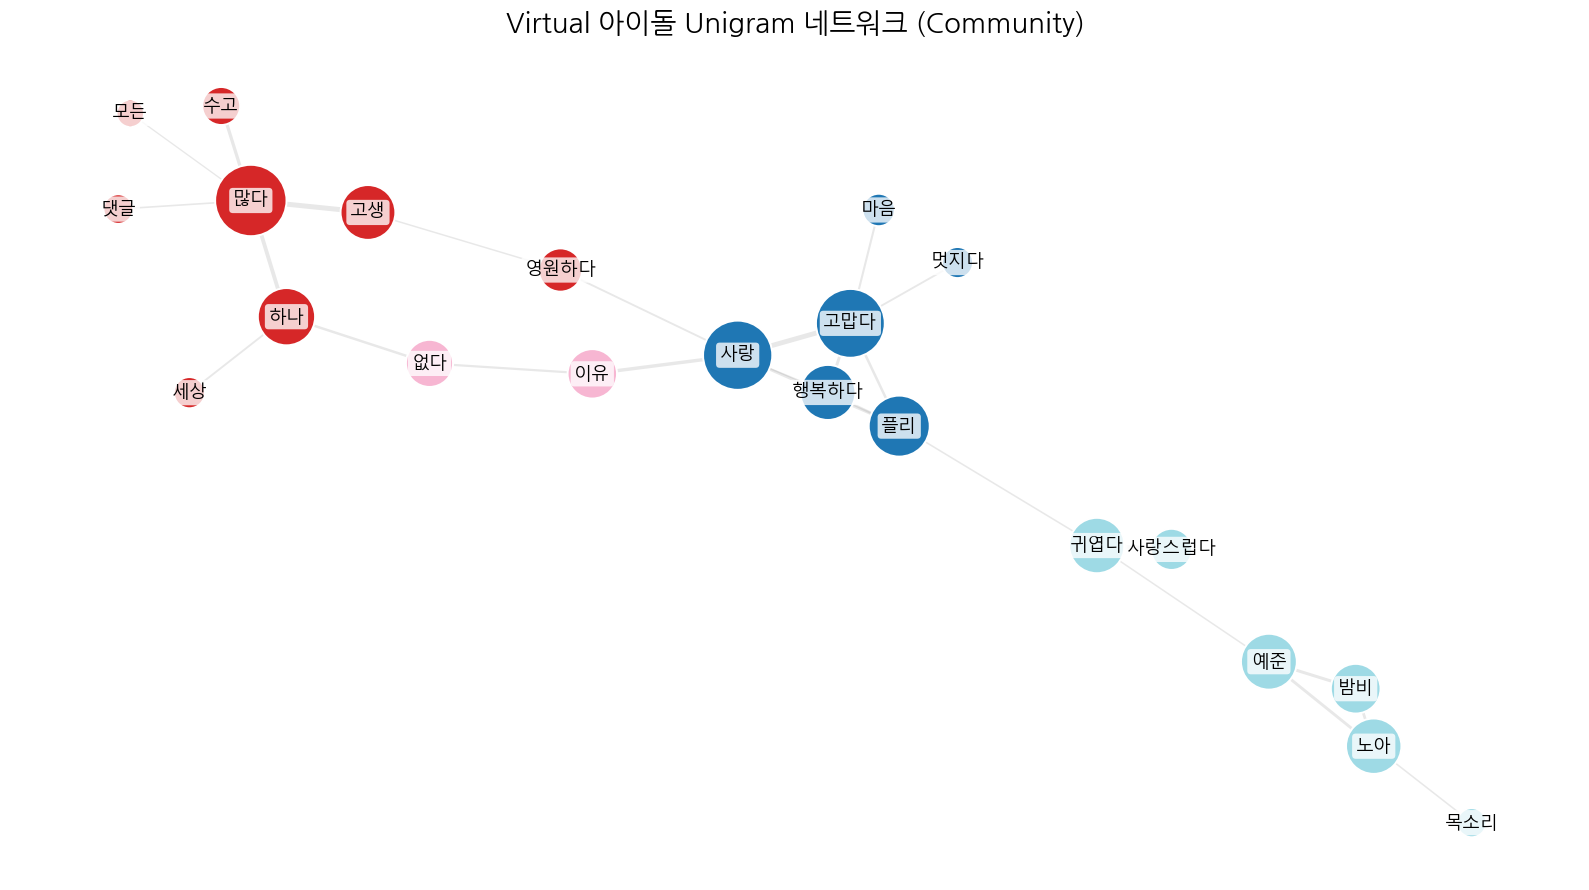

labels shown: 22  / candidates: 22


In [315]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import community as community_louvain

def pick_labels_no_overlap(pos, candidates, min_dist=0.10):
    """
    pos: dict node -> (x,y)
    candidates: 라벨 후보 노드 리스트(중요도 순)
    min_dist: 라벨 간 최소 거리 (클수록 라벨 수가 줄고 깔끔해짐)
    """
    chosen = []
    for n in candidates:
        x, y = pos[n]
        ok = True
        for m in chosen:
            x2, y2 = pos[m]
            if (x-x2)**2 + (y-y2)**2 < (min_dist**2):
                ok = False
                break
        if ok:
            chosen.append(n)
    return chosen

def draw_ppt_more_labels(
    G, title, out_png, out_svg,
    label_top=40,          # ← 라벨 후보 많이
    min_label_dist=0.085,  # ← 겹치면 자동 탈락(조절 포인트)
    fig_w=16, fig_h=9,
    font=20, label_font=13,
    layout_k=0.20, iterations=700,
    node_scale=1.5, edge_scale=1.2,
    crop_pad=0.08
):
    G = G.copy()
    G.remove_nodes_from(list(nx.isolates(G)))

    gcc = max(nx.connected_components(G), key=len)
    G = G.subgraph(gcc).copy()

    pos = nx.spring_layout(G, seed=42, k=layout_k, iterations=iterations)

    strength = dict(G.degree(weight="weight"))
    s = np.array([strength[n] for n in G.nodes()])
    s2 = np.sqrt(s)
    base_sizes = 260 + 1500 * (s2 - s2.min()) / (np.ptp(s2) + 1e-9)
    node_sizes = base_sizes * node_scale

    part = community_louvain.best_partition(G, weight="weight")
    comm = np.array([part[n] for n in G.nodes()])
    n_comms = len(set(comm))
    cmap = cm.get_cmap("tab20", max(n_comms, 1))
    node_colors = [cmap(c) for c in comm]

    ew = np.array([G[u][v]["weight"] for u, v in G.edges()])
    widths = 0.8 + 3.2 * (ew - ew.min()) / (np.ptp(ew) + 1e-9)
    widths = np.clip(widths, 0.8, 3.0) * edge_scale

    # ✅ 라벨 후보를 크게 잡고
    candidates = [n for n, _ in sorted(strength.items(), key=lambda x: x[1], reverse=True)[:label_top]]
    # ✅ 겹치면 자동 제외
    chosen = pick_labels_no_overlap(pos, candidates, min_dist=min_label_dist)
    labels = {n: n for n in chosen}

    plt.figure(figsize=(fig_w, fig_h))
    plt.title(title, fontsize=font, pad=12)

    nx.draw_networkx_edges(G, pos, width=widths, alpha=0.18, edge_color="gray")
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                           linewidths=1.4, edgecolors="white")

    nx.draw_networkx_labels(
        G, pos, labels=labels,
        font_size=label_font, font_family="Malgun Gothic",
        bbox=dict(boxstyle="round,pad=0.20", fc="white", ec="none", alpha=0.78)
    )

    # 자동 크롭
    xs = np.array([pos[n][0] for n in G.nodes()])
    ys = np.array([pos[n][1] for n in G.nodes()])
    xpad = (xs.max() - xs.min()) * crop_pad + 1e-9
    ypad = (ys.max() - ys.min()) * crop_pad + 1e-9
    plt.xlim(xs.min() - xpad, xs.max() + xpad)
    plt.ylim(ys.min() - ypad, ys.max() + ypad)

    plt.axis("off")
    plt.tight_layout()

    plt.savefig(out_png, dpi=600, bbox_inches="tight", transparent=True)
    plt.savefig(out_svg, bbox_inches="tight")
    plt.show()

    print("labels shown:", len(labels), " / candidates:", len(candidates))

# 사용 예:
draw_ppt_more_labels(
    G,
    title=f"{grp_name} 아이돌 Unigram 네트워크 (Community)",
    out_png=f"{grp_name}_unigram_network_morelabels.png",
    out_svg=f"{grp_name}_unigram_network_morelabels.svg",
    label_top=45,
    min_label_dist=0.08,   # 더 많은 라벨 원하면 0.06~0.07로 줄여
    label_font=13
)


## 2) N-gram

nodes: 80 edges: 127


C:\Users\user\AppData\Local\Temp\ipykernel_3444\3671131489.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", max(n_comms, 1))


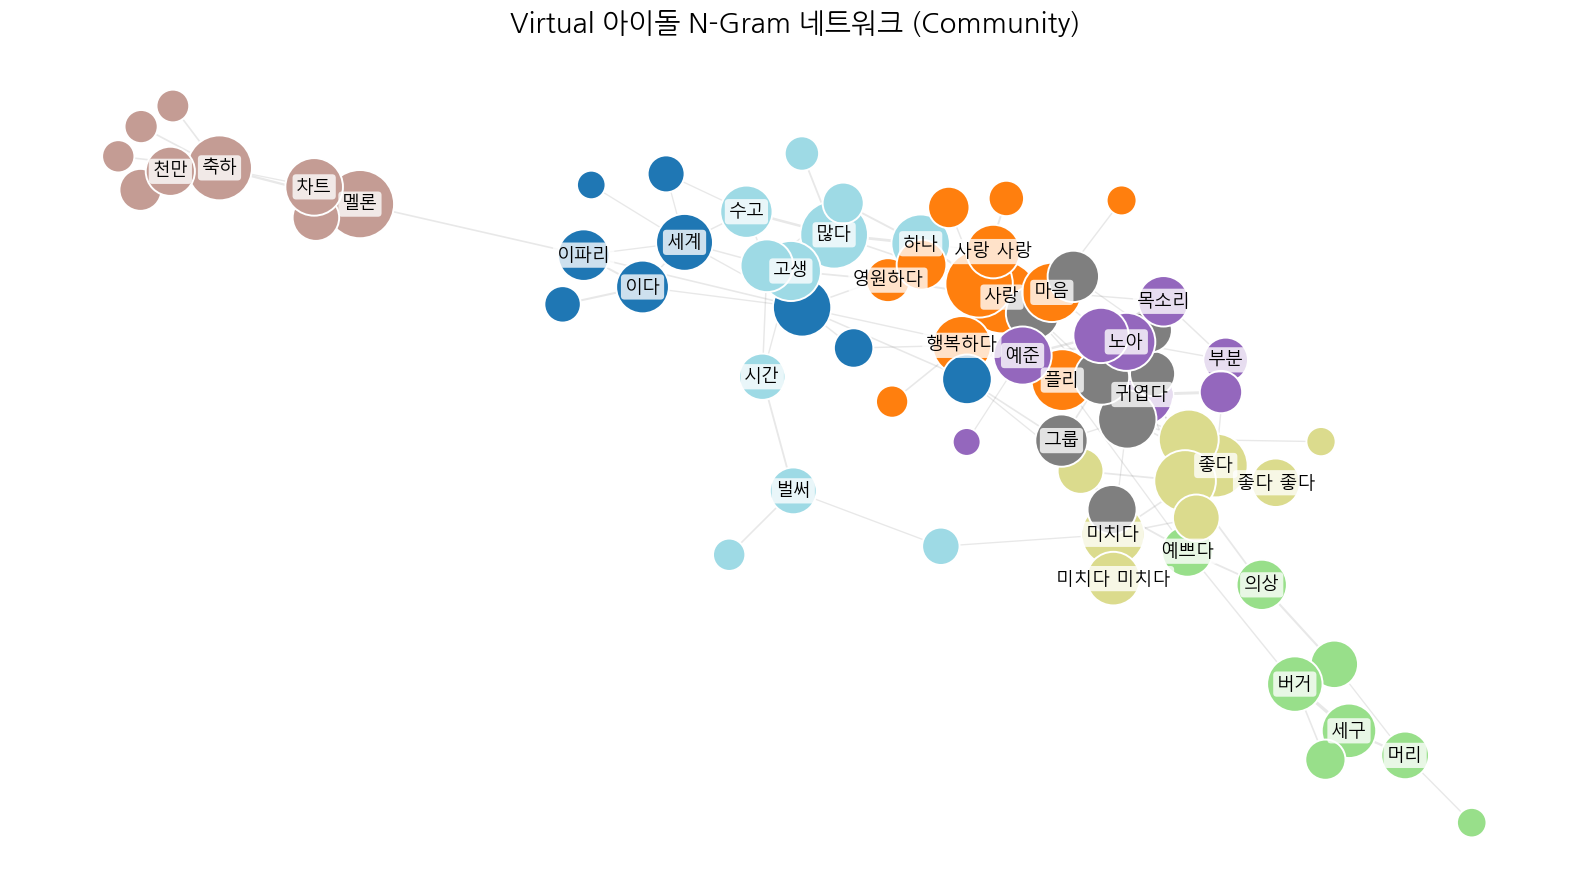

nodes: 74 edges: 127 labels shown: 34 communities: 8
saved: Virtual_ngram_network_ppt.png Virtual_ngram_network_ppt.svg


In [316]:
k = 7
percentage = 70
symmetric_mode = "min"

vec = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=n,
    min_df=5,            # 너무 희귀한 단어 제거
    max_df=0.8           # 너무 흔한 단어 제거
)
X = vec.fit_transform(doc_list)
terms = vec.get_feature_names_out()

mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
top_idx = np.argsort(mean_tfidf)[::-1][:n]   # 예: 상위 n개 단어만

X_top = X[:, top_idx]
terms_top = terms[top_idx]

M_cos = cosine_similarity(X_top.T)  # (3000 x 3000)면 manageable

M_plot = keep_topk_per_row(M_cos, k=k, symmetric=symmetric_mode)

vals = M_plot[M_plot > 0]
t = np.percentile(vals, 100-percentage)   # 상위 30%만 유지
M_plot[M_plot < t] = 0.0

G = nx.Graph()
G.add_nodes_from(terms_top)

# (i<j) 상삼각만 돌면서 엣지 추가
n = len(terms_top)
for i in range(n):
    for j in range(i+1, n):
        w = float(M_plot[i, j])
        if w > 0:
            G.add_edge(terms_top[i], terms_top[j], weight=w)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import community as community_louvain  # pip install python-louvain

# ---------- 라벨 겹침 완화 유틸 ----------
def pick_labels_no_overlap(pos, candidates, min_dist=0.07):
    chosen = []
    for n in candidates:
        x, y = pos[n]
        ok = True
        for m in chosen:
            x2, y2 = pos[m]
            if (x - x2) ** 2 + (y - y2) ** 2 < (min_dist ** 2):
                ok = False
                break
        if ok:
            chosen.append(n)
    return chosen

# ---------- PPT용 네트워크 드로잉 ----------
def draw_network_ppt(
    G,
    title,
    out_png,
    out_svg,
    keep="gcc",          # "gcc" or "all"
    label_top=45,        # 라벨 후보 수 (많이 주고)
    min_label_dist=0.065,# 라벨 간 최소 거리 (줄이면 더 많이 표시)
    fig_w=16, fig_h=9,   # PPT 비율
    title_font=20,
    label_font=13,
    layout_k=0.22,
    iterations=700,
    node_scale=1.45,
    edge_scale=1.15,
    crop_pad=0.08
):
    G = G.copy()
    G.remove_nodes_from(list(nx.isolates(G)))  # 고립 노드 제거

    if G.number_of_nodes() == 0:
        print("Graph is empty.")
        return

    # PPT 한 장이면 보통 GCC만 보여주는 게 가장 깔끔
    if keep == "gcc":
        gcc = max(nx.connected_components(G), key=len)
        G = G.subgraph(gcc).copy()

    # 레이아웃 안정화
    pos = nx.spring_layout(G, seed=42, k=layout_k, iterations=iterations)

    # 노드 크기: weighted degree(strength)
    strength = dict(G.degree(weight="weight"))
    s = np.array([strength[n] for n in G.nodes()])
    s2 = np.sqrt(s)
    base_sizes = 260 + 1500 * (s2 - s2.min()) / (np.ptp(s2) + 1e-9)
    node_sizes = base_sizes * node_scale

    # 커뮤니티 색상 (plotly 느낌: tab20)
    part = community_louvain.best_partition(G, weight="weight")
    comm = np.array([part[n] for n in G.nodes()])
    n_comms = len(set(comm))
    cmap = cm.get_cmap("tab20", max(n_comms, 1))
    node_colors = [cmap(c) for c in comm]

    # 엣지 두께: weight 기반 + clip
    if G.number_of_edges() > 0:
        ew = np.array([G[u][v]["weight"] for u, v in G.edges()])
        widths = 0.8 + 3.2 * (ew - ew.min()) / (np.ptp(ew) + 1e-9)
        widths = np.clip(widths, 0.8, 3.0) * edge_scale
    else:
        widths = 1.0

    # 라벨: 상위 label_top 후보 중에서 겹치면 자동 제거
    candidates = [n for n, _ in sorted(strength.items(), key=lambda x: x[1], reverse=True)[:label_top]]
    chosen = pick_labels_no_overlap(pos, candidates, min_dist=min_label_dist)
    labels = {n: n for n in chosen}

    # ----- draw -----
    plt.figure(figsize=(fig_w, fig_h))
    plt.title(title, fontsize=title_font, pad=12)

    nx.draw_networkx_edges(G, pos, width=widths, alpha=0.18, edge_color="gray")
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        linewidths=1.4,
        edgecolors="white"
    )

    nx.draw_networkx_labels(
        G, pos, labels=labels,
        font_size=label_font,
        font_family="Malgun Gothic",
        bbox=dict(boxstyle="round,pad=0.20", fc="white", ec="none", alpha=0.78)
    )

    # ✅ 자동 크롭(여백 제거) = PPT에서 “크게 보이는” 핵심
    xs = np.array([pos[n][0] for n in G.nodes()])
    ys = np.array([pos[n][1] for n in G.nodes()])
    xpad = (xs.max() - xs.min()) * crop_pad + 1e-9
    ypad = (ys.max() - ys.min()) * crop_pad + 1e-9
    plt.xlim(xs.min() - xpad, xs.max() + xpad)
    plt.ylim(ys.min() - ypad, ys.max() + ypad)

    plt.axis("off")
    plt.tight_layout()

    # PPT용 저장
    plt.savefig(out_png, dpi=600, bbox_inches="tight", transparent=True)
    plt.savefig(out_svg, bbox_inches="tight")
    plt.show()

    print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges(), "labels shown:", len(labels), "communities:", n_comms)
    print("saved:", out_png, out_svg)

# ---------------------------
# ✅ 너의 기존 코드: G 만들기까지 그대로 두고
# 아래 draw_network_ppt만 호출하면 됨
# ---------------------------

draw_network_ppt(
    G,
    title=f"{grp_name} 아이돌 N-Gram 네트워크 (Community)",
    out_png=f"{grp_name}_ngram_network_ppt.png",
    out_svg=f"{grp_name}_ngram_network_ppt.svg",
    keep="gcc",
    label_top=55,        # N-gram은 단어가 길어서 라벨 좀 더 주는 게 좋음
    min_label_dist=0.06, # 더 많이 보이게
    layout_k=0.20,
    node_scale=1.55,
    edge_scale=1.15
)


In [378]:
print("len(terms):", len(terms))
print("num bigrams:", np.sum(is_bigram))
print("sample terms:", terms[:30])
print("any term with space?:", any(" " in t for t in terms))

len(terms): 4988
num bigrams: 0
sample terms: ['가게' '가까이' '가깝다' '가나' '가늠' '가능' '가능하다' '가도' '가득' '가득하다' '가라' '가람이' '가면'
 '가문' '가뭄' '가발' '가방' '가볍다' '가보' '가사' '가사도' '가성' '가속' '가수' '가슴' '가시' '가오'
 '가요' '가요대전' '가요제']
any term with space?: False


In [379]:
vec2 = TfidfVectorizer(
    ngram_range=(2, 2),
    min_df=5,
    max_df=0.8,
    max_features=2000
)

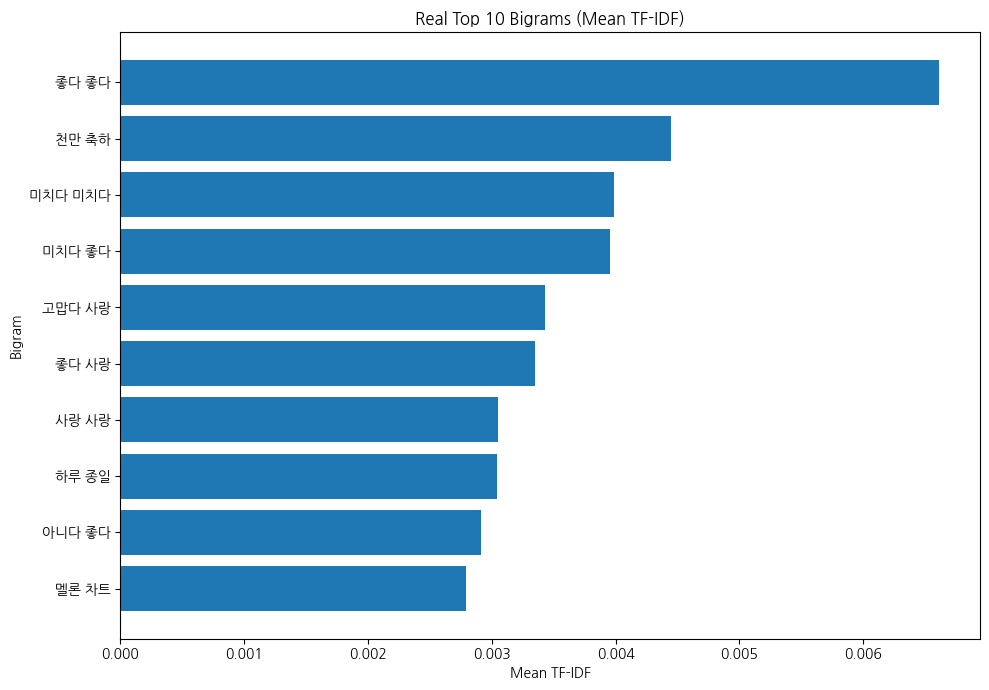

In [385]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

vec2 = TfidfVectorizer(
    ngram_range=(2, 2),
    min_df=5,
    max_df=0.8,
    max_features=2000
)

X2 = vec2.fit_transform(doc_list)
terms2 = vec2.get_feature_names_out()
mean2 = np.asarray(X2.mean(axis=0)).ravel()

# 1) term별 평균 tf-idf (너가 이미 만든 mean_tfidf 활용 가능)

# 2) bigram 마스크: 공백이 1개 있는 term (예: "노래 좋다")
is_bigram = np.array([t.count(" ") == 1 for t in terms2])

bigram_terms = terms2[is_bigram]
bigram_scores = mean2[is_bigram]

# 3) 상위 K 선택
top_k = 10
idx = np.argsort(bigram_scores)[::-1][:top_k]

top_terms = bigram_terms[idx][::-1]      # 역순: 아래가 낮고 위가 높게(가로막대)
top_scores = bigram_scores[idx][::-1]

# 4) plot
plt.figure(figsize=(10, 7))
plt.barh(top_terms, top_scores)
plt.title(f"{grp_name} Top {top_k} Bigrams (Mean TF-IDF)")
plt.xlabel("Mean TF-IDF")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()

# 6. LDA 분석 ( 담론 주제별 분화 시각화 )

## 1) 전처리

In [317]:
df = pd.read_csv(
    "../cocacoca0810/data/01_raw/processed/youtube_comments_clean.csv",
    index_col=0
)

df.head()

,video_id,comment_id,like_count,published_at,datetime,cleaned_comment
0,k5O1F_IS0mU,Ugykjh0_hVuTgqN8doR4AaABAg,0,2026-01-31T15:59:29Z,2026-01-31 15:59:29,그냥 얘들아 내가 진짜 애정한다 나 이렇게 애정해본 아이돌이 너네가 처음이고 콘서트...
1,k5O1F_IS0mU,Ugx1c4OKEnkVwGWBlFB4AaABAg,2,2026-01-23T04:29:25Z,2026-01-23 04:29:25,눈물이 난다
2,k5O1F_IS0mU,UgwaAbmKOm2vwOgFEFp4AaABAg,2,2026-01-20T01:52:56Z,2026-01-20 01:52:56,이 노래도 겁나 좋네
3,k5O1F_IS0mU,UgzquReVBuSocVLtI7t4AaABAg,3,2026-01-19T11:10:22Z,2026-01-19 11:10:22,패러블 이제 뉴세돌로 리와인드 다시 찍어 올려라 이세돌 더 이쁜 버전으로 보고 싶다
4,k5O1F_IS0mU,UgwM02x2Puib48rQTuF4AaABAg,2,2026-01-16T02:53:32Z,2026-01-16 02:53:32,언제 들어도 행복하고 좋은 노래


In [318]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 218104 entries, 0 to 218103
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   video_id         218104 non-null  str  
 1   comment_id       218104 non-null  str  
 2   like_count       218104 non-null  int64
 3   published_at     218104 non-null  str  
 4   datetime         218104 non-null  str  
 5   cleaned_comment  72796 non-null   str  
dtypes: int64(1), str(5)
memory usage: 10.0 MB


In [319]:
df = df.dropna()
df.info()

<class 'pandas.DataFrame'>
Index: 72796 entries, 0 to 218100
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   video_id         72796 non-null  str  
 1   comment_id       72796 non-null  str  
 2   like_count       72796 non-null  int64
 3   published_at     72796 non-null  str  
 4   datetime         72796 non-null  str  
 5   cleaned_comment  72796 non-null  str  
dtypes: int64(1), str(5)
memory usage: 3.9 MB


In [320]:
# 컬럼의 데이터가 전부 str 인지 확인
df["cleaned_comment"].apply(type).value_counts()

cleaned_comment
<class 'str'>    72796
Name: count, dtype: int64

In [321]:
video_to_group = {
    "8L001YT4k6k": "PLAVE",
    "EYG4ROejmyI": "PLAVE",
    "T_gJpnjJsnk": "PLAVE",

    "bltjk6NfDQM": "IVE",
    "B1ShLiq3EVc": "IVE",
    "6ZUIwj3FgUY": "IVE",
    
    "iUw3LPM7OBU": "RIIZE",
    "3_b5oKGndn0": "RIIZE",
    "TVqEwvbZP30": "RIIZE",
    
    "k5O1F_IS0mU": "ISEGYE IDOL",
    "rDFUl2mHIW4": "ISEGYE IDOL",
    "fff8P0kYexQ": "ISEGYE IDOL"
}

df["group"] = df["video_id"].map(video_to_group)
df["group"].value_counts()

group
IVE            27157
ISEGYE IDOL    21955
PLAVE          18720
RIIZE           4964
Name: count, dtype: int64

In [322]:
# V와 R 나누기 위한 컬럼 추가
is_real_mask = df['group'].str.contains(r'RIIZE|IVE', case=False)
df["idol_type"] = np.where(is_real_mask, "리얼", "버추얼")
df.head()

,video_id,comment_id,like_count,published_at,datetime,cleaned_comment,group,idol_type
0,k5O1F_IS0mU,Ugykjh0_hVuTgqN8doR4AaABAg,0,2026-01-31T15:59:29Z,2026-01-31 15:59:29,그냥 얘들아 내가 진짜 애정한다 나 이렇게 애정해본 아이돌이 너네가 처음이고 콘서트...,ISEGYE IDOL,버추얼
1,k5O1F_IS0mU,Ugx1c4OKEnkVwGWBlFB4AaABAg,2,2026-01-23T04:29:25Z,2026-01-23 04:29:25,눈물이 난다,ISEGYE IDOL,버추얼
2,k5O1F_IS0mU,UgwaAbmKOm2vwOgFEFp4AaABAg,2,2026-01-20T01:52:56Z,2026-01-20 01:52:56,이 노래도 겁나 좋네,ISEGYE IDOL,버추얼
3,k5O1F_IS0mU,UgzquReVBuSocVLtI7t4AaABAg,3,2026-01-19T11:10:22Z,2026-01-19 11:10:22,패러블 이제 뉴세돌로 리와인드 다시 찍어 올려라 이세돌 더 이쁜 버전으로 보고 싶다,ISEGYE IDOL,버추얼
4,k5O1F_IS0mU,UgwM02x2Puib48rQTuF4AaABAg,2,2026-01-16T02:53:32Z,2026-01-16 02:53:32,언제 들어도 행복하고 좋은 노래,ISEGYE IDOL,버추얼


In [323]:
df["idol_type"].value_counts()

idol_type
버추얼    40675
리얼     32121
Name: count, dtype: int64

In [324]:
real_df = df[is_real_mask]
real_df.shape

(32121, 8)

In [325]:
virtual_df = df[~is_real_mask]
virtual_df.shape

(40675, 8)

## 2-1) LDA 시각화 준비 ( tokenize + CountVectorize )

In [ ]:
## 느린코드
kiwi = Kiwi()

# STEP1. 전처리한 문장을 담을 빈리스트를 준비한다. sent_list
sent_list = []

# STEP2. df["text"]에서 문장을 하나씩 뺸다.
for sent in virtual_df["cleaned_comment"]:

    # STEP4. clean_sent를 토크나이징한다. (Kiwi형태소 분석기 사용) result
    result = kiwi.tokenize(sent)
    
    sub_list = []
    for x in result:
        word = x.form
        pos = x.tag
        
        if pos[0] in ["J", "E", "X"]:
            continue
        
        # ✔ 동사 / 형용사는 lemma 사용
        if pos.startswith(("V", "A")):
            word = x.lemma

        if len(word) > 1:
            sub_list.append(word)

    # STEP5. result를 " "를 구분자로 하나의 문자열로 합친다. result_str
    result_str = " ".join(sub_list)
    #print(f"orig: {sent}")
    #print(f"prep: {result_str}")
    # STEP6. result_str을 sent_list에 넣는다.
    sent_list.append(result_str)
    #print("="*50)

In [111]:
# 5~7배 빠른코드
kiwi = Kiwi()

sent_list = []

# STEP1. NaN 제거 + 리스트 변환
texts = real_df["cleaned_comment"].dropna().tolist()

# STEP2. 한번에 토큰화
tokenized = kiwi.tokenize(texts)

# STEP3. 결과 후처리
for tokens in tokenized:

    sub_list = []

    for x in tokens:

        pos = x.tag

        if pos[0] in ["J", "E", "X"]:
            continue

        word = x.lemma if pos.startswith(("V", "A")) else x.form

        if len(word) > 1:
            sub_list.append(word)

    sent_list.append(" ".join(sub_list))
    
print(len(sent_list))

32121


In [121]:
count_vectorizer = CountVectorizer(
    max_df=0.15,         # 전체 단어의 등장 비율이 p이상인 것만 사용
    min_df=3,           # 이 단어가 적어도 n개 이상 있는 것만 사용
    max_features=3000,  # 최대 몇 개까지 나타낼 것인가
    ngram_range=(1,2)   # 단어의 조합 설정(ex. 1개만 사용)
)
feat_vec = count_vectorizer.fit_transform(sent_list)
# 문장 -> 스페이스 기준으로 쪼갠다. -> 단어들이 나열
# 각 문장마다 단어가 몇번 들어가 있는지 카운트를 세고
feat_vec.shape

(32121, 3000)

In [122]:
# 1. Sparse Matrix를 일반 배열(Dense)로 변환: .toarray()
# 2. 열 이름(단어 목록) 가져오기: get_feature_names_out()
df_vec = pd.DataFrame(
    feat_vec.toarray(),
    columns=count_vectorizer.get_feature_names_out()
)

# 결과 확인
df_vec.head()

,가끔,가능,가다,가다 가다,가다 너무,가다 노래,가다 듣다,가다 보다,가다 싶다,가다 이다,...,흥하다,희망,히트,히트 치다,히트곡,힐링,힘내다,힘들다,힘들다 이다,힙합
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2-2) LDA 시각화 ( 리얼 )

In [90]:
lda = LatentDirichletAllocation(n_components=5) # 몇 개의 topic으로 할까요?
lda.fit(feat_vec)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",5
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [91]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, feat_vec, count_vectorizer)
pyLDAvis.display(vis)

## Topic 컬럼 추가

In [123]:
# 행: 문장 
# 열: 그룹(n_component)
# 값: 문장이 그룹에 포함될 확률
# ex. 문장1  [0.1  0.8  0.1]  -> 이 문장1은 그룹 2이다. 
sent_topic = lda.transform(feat_vec)
print(sent_topic.shape)

(32121, 5)


In [124]:
# STEP0. 빈 리스트 2개를 준비한다. - topic_idx_list, topic_prob_list
topic_idx_list = []
topic_prob_list = []

# STEP1. sent_topic에서 요소 하나하나씩 뽑는다. [0.01354521, 0.01171053, 0.97474426]
for sent in sent_topic:
    #print(sent)
    # STEP2. 이 문장을 어떤 그룹으로 분류할 건지(argmax()) - topic_idx
    topic_idx = sent.argmax()
    # STEP3. 이 문장이 분류되었을 떄 그 확률(max()) - topic_prob
    topic_prob = sent.max()
    
    # STEP4. topic_idx, topic_prob을 topic_idx_list, topic_prob_list에 담는다.
    topic_idx_list.append(topic_idx)
    topic_prob_list.append(topic_prob)
    #print(sent)
    #print(f"{topic_idx} 위치에 최댓값 {topic_prob:.4f}이 있습니다.")
    #print("="*50)

In [125]:
real_df["topic_idx"] = topic_idx_list
real_df["topic_prob"] = topic_prob_list
real_df.head()

,video_id,comment_id,like_count,published_at,datetime,cleaned_comment,group,idol_type,topic_idx,topic_prob
54701,6ZUIwj3FgUY,UgxJvLxGUKrWPAETuL94AaABAg,0,2026-02-02T07:58:11Z,2026-02-02 07:58:11,아이브 노래좋아요,IVE,리얼,4,0.547125
54704,6ZUIwj3FgUY,UgzyYrD3CM7JKcXgM3F4AaABAg,1,2026-02-02T00:22:14Z,2026-02-02 00:22:14,분에 도착합니다 오늘,IVE,리얼,4,0.596418
54706,6ZUIwj3FgUY,UgzAEJypgDO1Jo9nwyd4AaABAg,4,2026-02-01T13:38:03Z,2026-02-01 13:38:03,듣는 사람 손,IVE,리얼,1,0.542244
54711,6ZUIwj3FgUY,UgyfX8rY0t_vCbjDj6N4AaABAg,3,2026-02-01T00:42:09Z,2026-02-01 00:42:09,월일 분 초,IVE,리얼,0,0.200000
54717,6ZUIwj3FgUY,UgxIK4MVsRLtmQjhIAN4AaABAg,12,2026-01-31T16:10:19Z,2026-01-31 16:10:19,년에 듣는사람,IVE,리얼,1,0.542244


## 3-1) LDA 시각화 준비 2 ( tokenize + CountVectorize )

In [126]:
# 5~7배 빠른코드
kiwi = Kiwi()

sent_list = []

# STEP1. NaN 제거 + 리스트 변환
texts = virtual_df["cleaned_comment"].dropna().tolist()

# STEP2. 한번에 토큰화
tokenized = kiwi.tokenize(texts)

# STEP3. 결과 후처리
for tokens in tokenized:

    sub_list = []

    for x in tokens:

        pos = x.tag

        if pos[0] in ["J", "E", "X"]:
            continue

        word = x.lemma if pos.startswith(("V", "A")) else x.form

        if len(word) > 1:
            sub_list.append(word)

    sent_list.append(" ".join(sub_list))
    
print(len(sent_list))

40675


In [127]:
count_vectorizer = CountVectorizer(
    max_df=0.15,         # 전체 단어의 등장 비율이 p이상인 것만 사용
    min_df=3,           # 이 단어가 적어도 n개 이상 있는 것만 사용
    max_features=3000,  # 최대 몇 개까지 나타낼 것인가
    ngram_range=(1,2)   # 단어의 조합 설정(ex. 1개만 사용)
)
feat_vec = count_vectorizer.fit_transform(sent_list)
# 문장 -> 스페이스 기준으로 쪼갠다. -> 단어들이 나열
# 각 문장마다 단어가 몇번 들어가 있는지 카운트를 세고
feat_vec.shape

(40675, 3000)

In [128]:
# 1. Sparse Matrix를 일반 배열(Dense)로 변환: .toarray()
# 2. 열 이름(단어 목록) 가져오기: get_feature_names_out()
df_vec = pd.DataFrame(
    feat_vec.toarray(),
    columns=count_vectorizer.get_feature_names_out()
)

# 결과 확인
df_vec.head()

,가게,가까이,가까이 다가오다,가까이 오다,가깝다,가깝다 지다,가끔,가능,가다,가다 가다,...,흑흑,흘리다,흥얼거리다,흥하다,희다,히히,힐링,힘내다,힘들다,힘들다 이다
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3-2) LDA 시각화 ( 버추얼 )

In [95]:
lda = LatentDirichletAllocation(n_components=5) # 몇 개의 topic으로 할까요?
lda.fit(feat_vec)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",5
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [96]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, feat_vec, count_vectorizer)
pyLDAvis.display(vis)

## Topic 컬럼 추가 ( 버추얼 )

In [129]:
# 행: 문장 
# 열: 그룹(n_component)
# 값: 문장이 그룹에 포함될 확률
# ex. 문장1  [0.1  0.8  0.1]  -> 이 문장1은 그룹 2이다. 
sent_topic = lda.transform(feat_vec)
print(sent_topic.shape)

(40675, 5)


In [130]:
# STEP0. 빈 리스트 2개를 준비한다. - topic_idx_list, topic_prob_list
topic_idx_list = []
topic_prob_list = []

# STEP1. sent_topic에서 요소 하나하나씩 뽑는다. [0.01354521, 0.01171053, 0.97474426]
for sent in sent_topic:
    #print(sent)
    # STEP2. 이 문장을 어떤 그룹으로 분류할 건지(argmax()) - topic_idx
    topic_idx = sent.argmax()
    # STEP3. 이 문장이 분류되었을 떄 그 확률(max()) - topic_prob
    topic_prob = sent.max()
    
    # STEP4. topic_idx, topic_prob을 topic_idx_list, topic_prob_list에 담는다.
    topic_idx_list.append(topic_idx)
    topic_prob_list.append(topic_prob)
    #print(sent)
    #print(f"{topic_idx} 위치에 최댓값 {topic_prob:.4f}이 있습니다.")
    #print("="*50)

In [131]:
virtual_df["topic_idx"] = topic_idx_list
virtual_df["topic_prob"] = topic_prob_list
virtual_df.head()

,video_id,comment_id,like_count,published_at,datetime,cleaned_comment,group,idol_type,topic_idx,topic_prob
0,k5O1F_IS0mU,Ugykjh0_hVuTgqN8doR4AaABAg,0,2026-01-31T15:59:29Z,2026-01-31 15:59:29,그냥 얘들아 내가 진짜 애정한다 나 이렇게 애정해본 아이돌이 너네가 처음이고 콘서트...,ISEGYE IDOL,버추얼,4,0.332962
1,k5O1F_IS0mU,Ugx1c4OKEnkVwGWBlFB4AaABAg,2,2026-01-23T04:29:25Z,2026-01-23 04:29:25,눈물이 난다,ISEGYE IDOL,버추얼,4,0.799885
2,k5O1F_IS0mU,UgwaAbmKOm2vwOgFEFp4AaABAg,2,2026-01-20T01:52:56Z,2026-01-20 01:52:56,이 노래도 겁나 좋네,ISEGYE IDOL,버추얼,2,0.731673
3,k5O1F_IS0mU,UgzquReVBuSocVLtI7t4AaABAg,3,2026-01-19T11:10:22Z,2026-01-19 11:10:22,패러블 이제 뉴세돌로 리와인드 다시 찍어 올려라 이세돌 더 이쁜 버전으로 보고 싶다,ISEGYE IDOL,버추얼,2,0.353858
4,k5O1F_IS0mU,UgwM02x2Puib48rQTuF4AaABAg,2,2026-01-16T02:53:32Z,2026-01-16 02:53:32,언제 들어도 행복하고 좋은 노래,ISEGYE IDOL,버추얼,4,0.525795


In [ ]:
real_df.loc[real_df['topic_idx']==4,:].sort_values(by='topic_prob', ascending=False).head(50)